# Predicting the FIFA World Cup 2018

## Explorative Data Analysis and Preprocessing steps

In [327]:
# import core modules
import numpy as np
import pandas as pd
from IPython.display import display
from itertools import combinations

# import viz modules
import matplotlib.pyplot as plt
import seaborn as sns

# import machine learning modules
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV

# figures and styling
%matplotlib inline
sns.set()
plt.rcParams['figure.figsize'] = [20, 5]

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# load the data
matches = pd.read_csv('C:\\Data_Science\\World Cup 2018\\FIFA real world stats\\matches.csv', parse_dates=['date'])
teams = pd.read_csv('C:\\Data_Science\\World Cup 2018\\FIFA real world stats\\teams.csv')
wc_teams = pd.read_csv('C:\\Data_Science\\World Cup 2018\\FIFA real world stats\\wc2018qualified.csv')
cl_stats = pd.read_csv('C:\\Data_Science\\World Cup 2018\\FIFA real world stats\\champions_league.csv', sep=';')
rankings = pd.read_csv('C:\\Data_Science\\World Cup 2018\\FIFA real world stats\\fifa_ranking.csv')

display(matches.head())
matches.info()
display(teams.head())
teams.info()
display(wc_teams.head())
wc_teams.info()



,date,team1,team1Text,team2,team2Text,venue,IdCupSeason,CupName,team1Score,team2Score,statText,resText,team1PenScore,team2PenScore
0,1980-03-26,CYP,Cyprus,IRL,Republic of Ireland,NaN,51,FIFA WC 1982 Prel. Comp. UEFA,2,3,NaN,2-3,NaN,NaN
1,1980-03-26,ISR,Israel,NIR,Northern Ireland,NaN,51,FIFA WC 1982 Prel. Comp. UEFA,0,0,NaN,0-0,NaN,NaN
2,1980-06-02,ISL,Iceland,WAL,Wales,NaN,51,FIFA WC 1982 Prel. Comp. UEFA,0,4,NaN,0-4,NaN,NaN
3,1980-06-04,FIN,Finland,BUL,Bulgaria,NaN,51,FIFA WC 1982 Prel. Comp. UEFA,0,2,NaN,0-2,NaN,NaN
4,1980-06-18,SWE,Sweden,ISR,Israel,NaN,51,FIFA WC 1982 Prel. Comp. UEFA,1,1,NaN,1-1,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11404 entries, 0 to 11403
Data columns (total 14 columns):
date             11404 non-null datetime64[ns]
team1            11404 non-null object
team1Text        11404 non-null object
team2            11404 non-null object
team2Text        11404 non-null object
venue            0 non-null float64
IdCupSeason      11404 non-null int64
CupName          11404 non-null object
team1Score       11404 non-null int64
team2Score       11404 non-null int64
statText         166 non-null object
resText          11128 non-null object
team1PenScore    166 non-null float64
team2PenScore    166 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(3), object(7)
memory usage: 1.2+ MB


,confederation,name,fifa_code,ioc_code
0,CAF,Algeria,ALG,ALG
1,CAF,Angola,ANG,ANG
2,CAF,Benin,BEN,BEN
3,CAF,Botswana,BOT,BOT
4,CAF,Burkina Faso,BFA,BUR


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 4 columns):
confederation    222 non-null object
name             222 non-null object
fifa_code        222 non-null object
ioc_code         222 non-null object
dtypes: object(4)
memory usage: 7.0+ KB


,name,draw
0,RUS,A1
1,KSA,A2
2,EGY,A3
3,URU,A4
4,POR,B1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 2 columns):
name    32 non-null object
draw    32 non-null object
dtypes: object(2)
memory usage: 592.0+ bytes


__Takeaway__: 

We see that there is a lot of missing data for the statText, team1PenScore and team2PenScore columns. The statText column has data for matches that ended in either over-time or penalty shootouts. The PenScore columns only has data when a match resulted in a penalty shootout. We could impute some data to indicate that the games didn't end in a penalty shootout, but because penalty shootouts are seen as something that's more based on luck than skills, we will drop the features here.

We also see that there are missing values for the venue column. This data is interesting because of the phenomenon that the home team is seen as having a better chance at winning. We will have to impute the missing values with neutral values.

In [328]:
# let's map former countries etc to their current nations

countrymapping = {
    'FRG': 'GER',
    'TCH': 'CZE',
    'URS': 'RUS',
    'SCG': 'SRB',
    'ZAI': 'COD'
                 }

matches[['team1', 'team2']] = matches[['team1', 'team2']].replace(countrymapping.keys(), list(countrymapping.values()))

# drop statText, team1PenScore & team2PenScore
matches = matches.drop(columns=['statText', 'team1PenScore', 'team2PenScore'])

# impute neutral for missing venues values
matches.venue = matches.venue.fillna(value='neutral')

# insert a match id for future use
matches['matchId'] = np.arange(matches.shape[0])

# we'll only use data from 1993 and up
matches = matches[matches['date'] > '1993-01-01']
print(matches.info())
matches.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8908 entries, 2496 to 11403
Data columns (total 12 columns):
date           8908 non-null datetime64[ns]
team1          8908 non-null object
team1Text      8908 non-null object
team2          8908 non-null object
team2Text      8908 non-null object
venue          8908 non-null object
IdCupSeason    8908 non-null int64
CupName        8908 non-null object
team1Score     8908 non-null int64
team2Score     8908 non-null int64
resText        8654 non-null object
matchId        8908 non-null int32
dtypes: datetime64[ns](1), int32(1), int64(3), object(7)
memory usage: 869.9+ KB
None


,date,team1,team1Text,team2,team2Text,venue,IdCupSeason,CupName,team1Score,team2Score,resText,matchId
2496,1993-04-08,JPN,Japan,THA,Thailand,neutral,77,FIFA WC 1994 Prel. Comp. AFC,1,0,1-0,2496
2497,1993-04-08,SRI,Sri Lanka,UAE,United Arab Emirates,neutral,77,FIFA WC 1994 Prel. Comp. AFC,0,4,0-4,2497
2498,1993-04-09,QAT,Qatar,IDN,Indonesia,neutral,77,FIFA WC 1994 Prel. Comp. AFC,3,1,3-1,2498
2499,1993-04-09,PRK,Korea DPR,VIE,Vietnam,neutral,77,FIFA WC 1994 Prel. Comp. AFC,3,0,3-0,2499
2500,1993-04-11,PRK,Korea DPR,SIN,Singapore,neutral,77,FIFA WC 1994 Prel. Comp. AFC,2,1,2-1,2500


In [329]:
# is there any bias in the way that team1 and team2 performs?
np.mean(matches.team1Score - matches.team2Score)

0.5363718006286484

As we can tell by the fact that team1 on average scores 0.54 more goals than team 2 suggests that we need to randomize the way that the teams are assigned to team1 and team2. It seems that team1 is defined as the home team - and we all know that the home team has an advantage :)

In [371]:
# randomizing the assignment of teams to team1 and team2
np.random.seed(42)

#sample = matches.sample(int(len(matches)), random_state=4342)
rows_to_swap = np.random.choice(matches.index.values, size=int(len(matches)/2), replace=False)


team1_col = matches['team1'].copy()
team2_col = matches['team2'].copy()
team1Text_col = matches['team1Text'].copy()
team2Text_col = matches['team2Text'].copy()
team1Score_col = matches['team1Score'].copy()
team2Score_col = matches['team2Score'].copy()

matches.loc[rows_to_swap, 'team1'] = team2_col[rows_to_swap]
matches.loc[rows_to_swap, 'team2'] = team1_col[rows_to_swap]
matches.loc[rows_to_swap, 'team1Text'] = team2Text_col[rows_to_swap]
matches.loc[rows_to_swap, 'team2Text'] = team1Text_col[rows_to_swap]
matches.loc[rows_to_swap, 'team1Score'] = team2Score_col[rows_to_swap]
matches.loc[rows_to_swap, 'team2Score'] = team1Score_col[rows_to_swap]

matches.drop(columns='resText');

In [331]:
# we should see a much lower difference here now
np.mean(matches.team1Score - matches.team2Score)

0.025145936237090254

In [332]:
# here we create two new columns indicating whether the team is home or away
matches['team1Home'] = matches[['team1Text', 'venue']].apply(lambda x: x['team1Text'] in x['venue'], axis=1)
matches['team2Home'] = matches[['team2Text', 'venue']].apply(lambda x: x['team2Text'] in x['venue'], axis=1)

# some cases has both teams being home (congo & congo DR). Here we'll set team1 as home
matches['team2Home'] = matches[['team1Home', 'team2Home']].apply(
    lambda x: False if (x['team1Home'] == True) & (x['team2Home'] == True) else matches['team2Home'], axis=1)

# if the venue is labeled neutral (missing values) or if both teams are away
matches['neutralVenue'] = matches[['venue', 'team1Home', 'team2Home']].apply(
    lambda x: True if (x['team1Home'] == False) & (x['team2Home'] == False 
    or x['venue'] == 'neutral') else False, axis=1) 


In [333]:
# creating new column for friendly matches
matches['friendly'] = matches.CupName == 'Friendly'

# creating new column for qualification matches
matches['qualifier'] = matches.CupName.str.contains('Qual')

# creating new column for finals matches
matches['finals'] = matches.CupName.str.contains('Final|Confederation')

# we don't want to deal with data based on friendly matches, only official matches
matches = matches.loc[matches.friendly != True]
matches.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8908 entries, 2496 to 11403
Data columns (total 18 columns):
date            8908 non-null datetime64[ns]
team1           8908 non-null object
team1Text       8908 non-null object
team2           8908 non-null object
team2Text       8908 non-null object
venue           8908 non-null object
IdCupSeason     8908 non-null int64
CupName         8908 non-null object
team1Score      8908 non-null int64
team2Score      8908 non-null int64
resText         8654 non-null object
matchId         8908 non-null int32
team1Home       8908 non-null bool
team2Home       8908 non-null bool
neutralVenue    8908 non-null bool
friendly        8908 non-null bool
qualifier       8908 non-null bool
finals          8908 non-null bool
dtypes: bool(6), datetime64[ns](1), int32(1), int64(3), object(7)
memory usage: 922.1+ KB


In [334]:
# now we'll make a team performance dataframe

# first we define the features for each team
team1 = {
        'matchId': matches.matchId,
        'date': matches.date,
        'name': matches.team1,
        'opponentName': matches.team2,
        'homeVenue': matches.team1Home,
        'neutralVenue': matches.neutralVenue,
        'goals_self': matches.team1Score,
        'goals_opp': matches.team2Score,
        'goals_diff': matches.team1Score - matches.team2Score,
        'w': (matches.team1Score > matches.team2Score),
        'l': (matches.team1Score < matches.team2Score),
        'd': (matches.team1Score == matches.team2Score),
        'qualifier': matches.qualifier,
        'finals': matches.finals
        }

team2 = {
        'matchId': matches.matchId,
        'date': matches.date,
        'name': matches.team2,
        'opponentName': matches.team1,
        'homeVenue': matches.team2Home,
        'neutralVenue': matches.neutralVenue,
        'goals_self': matches.team2Score,
        'goals_opp': matches.team1Score,
        'goals_diff': matches.team2Score - matches.team1Score,
        'w': (matches.team2Score > matches.team1Score),
        'l': (matches.team2Score < matches.team1Score),
        'd': (matches.team2Score == matches.team1Score),
        'qualifier': matches.qualifier,
        'finals': matches.finals
        }

# then we make create a dataframe for each of the set of features we want
temp_teamperf1 = pd.DataFrame(team1, columns=team1.keys())

temp_teamperf2 = pd.DataFrame(team2, columns=team2.keys())

# and merge them together
teamperf = temp_teamperf1.append(temp_teamperf2).sort_values('matchId')


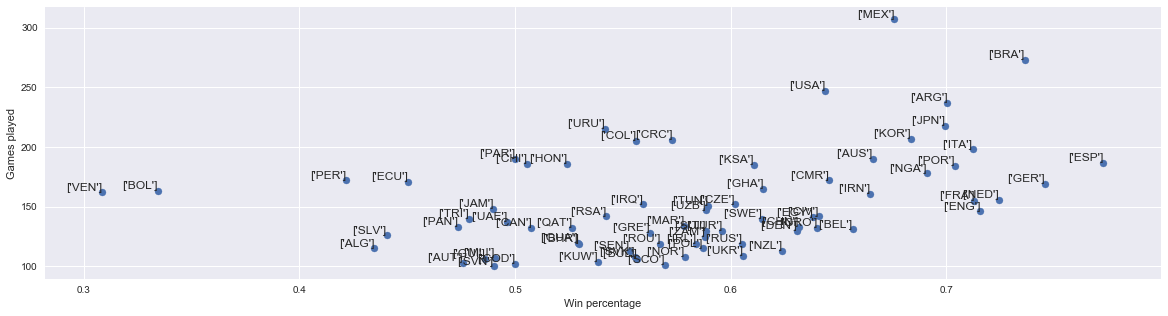

In [335]:
# let's check out the win percentage for teams who have played at least 100 matches

# define a function for calculating the win percentage
def winpercentage(total, wins, draws):
    return ((wins + 0.5 * draws) / total)

# define a function for plotting the win percentage and number of games played
def plt_winpercentage(teamperf, mingames):
    
    # get the nations with more than -mingames- amount of games played
    teamperf_grouped = teamperf.groupby(['name']).filter(lambda x: x['w'].sum() + x['d'].sum() + x['l'].sum() >= mingames)
    teamperf_grouped.groupby(['name'])
    
    loss = teamperf_grouped.groupby(['name'])['l'].sum()
    wins = teamperf_grouped.groupby(['name'])['w'].sum()
    draws = teamperf_grouped.groupby(['name'])['d'].sum()
    total = loss + wins + draws
    
    winpercent = winpercentage(total, wins, draws)
          
    plt.scatter(winpercent, total)
    for name, x, y in zip(teamperf_grouped.groupby(['name'])['name'].unique(), winpercent, total):
        plt.annotate(
            name,
            xy=(x, y), xytext=(0, 0),
            textcoords='offset points', ha='right', va='bottom')
    plt.xlabel('Win percentage')
    plt.ylabel('Games played')
    plt.show()
         
plt_winpercentage(teamperf, 100)


__Takeaway:__ It seems that Germany, Brazil and Spain are the top 3 teams with the highest win percentage of all time.



In [336]:
# let's take a look at the different score frequencies

scores = matches[['team1Score', 'team2Score']]

scores, score_counts = np.unique(scores.values, return_counts=True, axis=0)
scores = [str(x) for x in scores]
score_freq = score_counts / len(matches)

scores_df = pd.DataFrame({'scores': scores , 'counts': score_counts, 'freq': score_freq}, columns=['scores', 'counts', 'freq'])
display(scores_df.sort_values('freq', ascending=False).head(10))


,scores,counts,freq
18,[1 1],856,0.096093
1,[0 1],807,0.090593
17,[1 0],771,0.086551
0,[0 0],692,0.077683
29,[2 0],584,0.065559
2,[0 2],572,0.064212
30,[2 1],571,0.064100
19,[1 2],557,0.062528
38,[3 0],371,0.041648
3,[0 3],338,0.037943


__Takeaway:__ It seems that 1-1, 0-1 and 1-0 are the top 3 most common scores

,goals per match,counts,freq
2,2,2012,0.225864
3,3,1837,0.206219
1,1,1578,0.177144
4,4,1236,0.138752
5,5,725,0.081388
0,0,692,0.077683
6,6,390,0.043781
7,7,221,0.024809
8,8,96,0.010777
9,9,49,0.005501


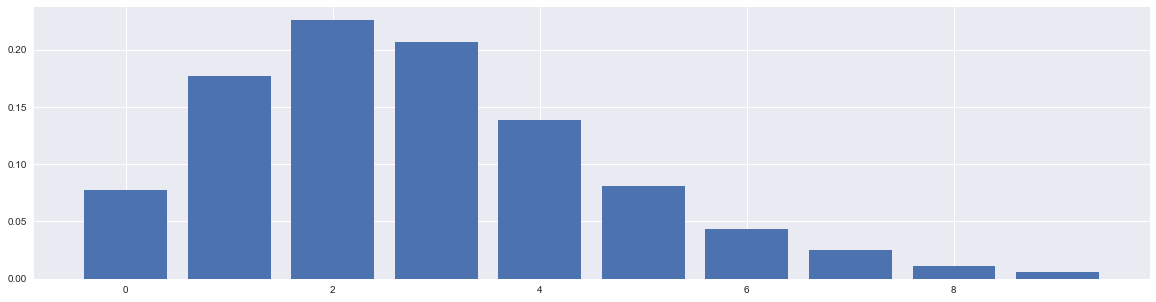

In [337]:
# let's see how many goals are typically scored per match
gpm = matches.team1Score + matches.team2Score

gpm, gpm_counts = np.unique(gpm, return_counts=True, axis=0)
gpm_freq = gpm_counts / len(matches)

gpm_df = pd.DataFrame({'goals per match': gpm, 'counts': gpm_counts, 'freq': gpm_freq}, columns=['goals per match', 'counts', 'freq'])
display(gpm_df.sort_values('freq', ascending=False).head(10))

plt.bar(gpm[:10], gpm_freq[:10])
plt.show()

__Takeaway:__ Two goals per match seems to occur most frequently, followed by 3 per match and 1 per match. Surprisingly, 4 and 5 goals per match seems to occur more often than 0 goals per match with our data.

,goal diff per match,counts,freq
0,0,1914,0.214863
35,-1,1511,0.169623
1,1,1497,0.168051
2,2,922,0.103502
34,-2,875,0.098226
3,3,510,0.057252
33,-3,501,0.056242
32,-4,264,0.029636
4,4,254,0.028514
31,-5,156,0.017512


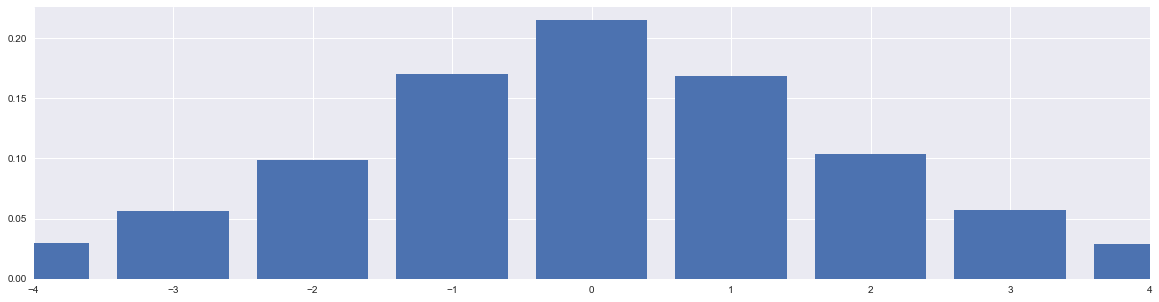

In [338]:
# let's look at the most occuring goal differentials
goaldiff = matches.team1Score - matches.team2Score

goaldiff, goaldiff_counts = np.unique(goaldiff, return_counts=True, axis=0)
goaldiff_freq = goaldiff_counts / len(matches)

goaldiff_df = pd.DataFrame({'goal diff per match': goaldiff, 'counts': goaldiff_counts, 'freq': goaldiff_freq}, columns=['goal diff per match', 'counts', 'freq'])
display(goaldiff_df.sort_values('freq', ascending=False).head(10))

plt.bar(goaldiff, goaldiff_freq)
plt.xlim([-4, 4])
plt.show()

__Takeaway__: It would seem that the most frequent goal difference is 0, which means draws - but a lot of games has one side winning by 1.

In [339]:
# let's see how many outliers we have with regards to goal differentials
# here, we'll define outlier goal differentials as being above 7
outliers = matches[matches.team1Score - matches.team2Score > 7]
print('We have {0} games with outliers, or {1:1.2f}% of total'.format(len(outliers), len(outliers)/len(matches)*100))


We have 80 games with outliers, or 0.90% of total


In [340]:
# we only have 0.90% of our data affected by outliers
# let's go ahead and remove that from our team performance dataframe
teamperf = teamperf[teamperf['goals_diff'] > -7]
teamperf = teamperf[teamperf['goals_diff'] < +7]

In [341]:
# Because each of the confederations have varying skill levels
# we'll adopt FIFA's own regional strength scores: 
# https://en.wikipedia.org/wiki/FIFA_World_Rankings#Regional_strength

regional_strength = pd.DataFrame(
    {'confederation': ['UEFA', 'CONMEBOL', 'CONCACAF', 'AFC', 'CAF', 'OFC'],
     'strength': [0.99, 1.00, 0.85, 0.85, 0.85, 0.85]}, 
     columns=['confederation', 'strength'])

# merge the regional strength with the teams dataframe
teams = teams.merge(regional_strength, on='confederation')

# take only the two columns for our merger dataframe
teams_merge = teams[['fifa_code', 'strength']]

# merge with teamperf

teamperf = teamperf.merge(teams_merge, left_on='opponentName', right_on='fifa_code')

# dropping duplicated rows
teamperf = teamperf.drop_duplicates()

In [342]:
teamperf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17251 entries, 0 to 17425
Data columns (total 16 columns):
matchId         17251 non-null int32
date            17251 non-null datetime64[ns]
name            17251 non-null object
opponentName    17251 non-null object
homeVenue       17251 non-null bool
neutralVenue    17251 non-null bool
goals_self      17251 non-null int64
goals_opp       17251 non-null int64
goals_diff      17251 non-null int64
w               17251 non-null bool
l               17251 non-null bool
d               17251 non-null bool
qualifier       17251 non-null bool
finals          17251 non-null bool
fifa_code       17251 non-null object
strength        17251 non-null float64
dtypes: bool(7), datetime64[ns](1), float64(1), int32(1), int64(3), object(3)
memory usage: 1.4+ MB


In [343]:
# now we'll add information about how many Champions League players
# each team have had in total since 1980 - because CL is regarded
# as the best league in the world

teamperf = teamperf.merge(cl_stats, how='left', left_on='name', right_on='nation')
teamperf = teamperf.drop(columns=['nation', 'total_cl_winners'])
teamperf = teamperf.fillna(0)

In [344]:
teamperf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17251 entries, 0 to 17250
Data columns (total 17 columns):
matchId             17251 non-null int32
date                17251 non-null datetime64[ns]
name                17251 non-null object
opponentName        17251 non-null object
homeVenue           17251 non-null bool
neutralVenue        17251 non-null bool
goals_self          17251 non-null int64
goals_opp           17251 non-null int64
goals_diff          17251 non-null int64
w                   17251 non-null bool
l                   17251 non-null bool
d                   17251 non-null bool
qualifier           17251 non-null bool
finals              17251 non-null bool
fifa_code           17251 non-null object
strength            17251 non-null float64
total_cl_players    17251 non-null float64
dtypes: bool(7), datetime64[ns](1), float64(2), int32(1), int64(3), object(3)
memory usage: 1.5+ MB


In [345]:
# next we'll add FIFAs rankings to the teams
rankings = rankings.loc[:,['rank', 'country_abrv', 'rank_date' ]]

# transform to proper dates
rankings['rank_date'] = pd.to_datetime(rankings['rank_date'])

# forward fill the rank so that we have a rank for every day
rankings = rankings.set_index(['rank_date'])\
            .groupby(['country_abrv'], group_keys=False)\
            .resample('D').first()\
            .fillna(method='ffill')\
            .reset_index()

In [347]:
# now we'll add the rankings to the team features
teamperf = teamperf.merge(rankings, how='left', left_on=['date', 'name'], right_on=['rank_date', 'country_abrv'])

teamperf = teamperf[[
    'matchId',
    'date',
    'name',
    'opponentName',
    'homeVenue',
    'neutralVenue',
    'goals_self',
    'goals_opp',
    'goals_diff',
    'w',
    'l',
    'd',
    'qualifier',
    'finals',
    'fifa_code',
    'strength',
    'total_cl_players',
    'rank'
]]

# let's check our our current dataframe
print(teamperf.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17251 entries, 0 to 17250
Data columns (total 18 columns):
matchId             17251 non-null int32
date                17251 non-null datetime64[ns]
name                17251 non-null object
opponentName        17251 non-null object
homeVenue           17251 non-null bool
neutralVenue        17251 non-null bool
goals_self          17251 non-null int64
goals_opp           17251 non-null int64
goals_diff          17251 non-null int64
w                   17251 non-null bool
l                   17251 non-null bool
d                   17251 non-null bool
qualifier           17251 non-null bool
finals              17251 non-null bool
fifa_code           17251 non-null object
strength            17251 non-null float64
total_cl_players    17251 non-null float64
rank                16636 non-null float64
dtypes: bool(7), datetime64[ns](1), float64(3), int32(1), int64(3), object(3)
memory usage: 1.6+ MB
None


In [348]:
# fill in missing rankings with average for each team
teamperf['rank'] = teamperf.groupby('name').fillna(teamperf['rank'].mean())

## Feature Engineering

We'll do some feature engineering to come up with features indicating the form of the teams - both short term, medium term and long term. We'll do this by looking at the last 10, 30 and 50 games and doing some estimation on these.

In [349]:
# we'll define a new dataframe containing the features for each team
team_features = teamperf.copy()

# a function that takes in which a variable (w, l, d etc.) and a window size (10, 30 50)
# we first ensure that the dataframe is sorted and grouped before applying the rolling
# function as well as calculating the percentages for each rolling sum.
def rolling_windows(variable, window):
    return (team_features.sort_values(['name', 'date'])
            .groupby('name')[variable].apply(lambda x: x.rolling(window+1).sum() - x))/window

# rolling windows: wins
team_features['last10games_w_per'] = rolling_windows('w', 10)
team_features['last30games_w_per'] = rolling_windows('w', 30)
team_features['last50games_w_per'] = rolling_windows('w', 50)

# rolling windows: losses
team_features['last10games_l_per'] = rolling_windows('l', 10)
team_features['last30games_l_per'] = rolling_windows('l', 30)
team_features['last50games_l_per'] = rolling_windows('l', 30)

# rolling windows: draws
team_features['last10games_d_per'] = rolling_windows('d', 10)
team_features['last30games_d_per'] = rolling_windows('d', 30)
team_features['last50games_d_per'] = rolling_windows('d', 50)

# rolling windows: goal differences
team_features['last10games_gd_per'] = rolling_windows('goals_diff', 10)
team_features['last30games_gd_per'] = rolling_windows('goals_diff', 30)
team_features['last50games_gd_per'] = rolling_windows('goals_diff', 50)

# rolling windows: opponent strength
team_features['last10games_opp_str_per'] = rolling_windows('strength', 10)
team_features['last30games_opp_str_per'] = rolling_windows('strength', 30)
team_features['last50games_opp_str_per'] = rolling_windows('strength', 50)

# check for missing values
team_features.info()

# fill out missing values for rolling window with 0
team_features = team_features.fillna(0)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17251 entries, 0 to 17250
Data columns (total 33 columns):
matchId                    17251 non-null int32
date                       17251 non-null datetime64[ns]
name                       17251 non-null object
opponentName               17251 non-null object
homeVenue                  17251 non-null bool
neutralVenue               17251 non-null bool
goals_self                 17251 non-null int64
goals_opp                  17251 non-null int64
goals_diff                 17251 non-null int64
w                          17251 non-null bool
l                          17251 non-null bool
d                          17251 non-null bool
qualifier                  17251 non-null bool
finals                     17251 non-null bool
fifa_code                  17251 non-null object
strength                   17251 non-null float64
total_cl_players           17251 non-null float64
rank                       17251 non-null object
last10games_w_per

In [350]:
# now we'll add these new features to our matches, so we have the stats for each
# team in each matchup

match_features = matches.copy()

match_features = match_features.merge(team_features, left_on=['matchId', 'team1'], 
                                      right_on=['matchId','name'])
match_features = match_features.merge(team_features, left_on=['matchId', 'team2'], 
                                      right_on=['matchId','name'], suffixes=['.t1', '.t2'])
print(match_features.columns)
match_features['outcome'] = match_features['goals_diff.t1']

match_features = match_features[[
    'date',
    'team1',
    'team2',
    'team1Home',
    'team2Home',
    'neutralVenue',
    'qualifier',
    'finals',
    'strength.t1',
    'strength.t2',
    'rank.t1',
    'rank.t2',
    'total_cl_players.t1',
    'total_cl_players.t2',
    'last10games_w_per.t1',
    'last30games_w_per.t1',
    'last50games_w_per.t1',
    'last10games_l_per.t1',
    'last30games_l_per.t1',
    'last50games_l_per.t1',
    'last10games_d_per.t1',
    'last30games_d_per.t1',
    'last50games_d_per.t1',
    'last10games_gd_per.t1',
    'last30games_gd_per.t1',
    'last50games_gd_per.t1',
    'last10games_opp_str_per.t1',
    'last30games_opp_str_per.t1',
    'last50games_opp_str_per.t1',
    'last10games_w_per.t2',
    'last30games_w_per.t2',
    'last50games_w_per.t2',
    'last10games_l_per.t2',
    'last30games_l_per.t2',
    'last50games_l_per.t2',
    'last10games_d_per.t2',
    'last30games_d_per.t2',
    'last50games_d_per.t2',
    'last10games_gd_per.t2',
    'last30games_gd_per.t2',
    'last50games_gd_per.t2',
    'last10games_opp_str_per.t2',
    'last30games_opp_str_per.t2',
    'last50games_opp_str_per.t2',
    'outcome'
    ]]

# check if we have missing values
print(match_features.info())

Index(['date_x', 'team1', 'team1Text', 'team2', 'team2Text', 'venue',
       'IdCupSeason', 'CupName', 'team1Score', 'team2Score', 'resText',
       'matchId', 'team1Home', 'team2Home', 'neutralVenue_x', 'friendly',
       'qualifier_x', 'finals_x', 'date_y', 'name.t1', 'opponentName.t1',
       'homeVenue.t1', 'neutralVenue_y', 'goals_self.t1', 'goals_opp.t1',
       'goals_diff.t1', 'w.t1', 'l.t1', 'd.t1', 'qualifier_y', 'finals_y',
       'fifa_code.t1', 'strength.t1', 'total_cl_players.t1', 'rank.t1',
       'last10games_w_per.t1', 'last30games_w_per.t1', 'last50games_w_per.t1',
       'last10games_l_per.t1', 'last30games_l_per.t1', 'last50games_l_per.t1',
       'last10games_d_per.t1', 'last30games_d_per.t1', 'last50games_d_per.t1',
       'last10games_gd_per.t1', 'last30games_gd_per.t1',
       'last50games_gd_per.t1', 'last10games_opp_str_per.t1',
       'last30games_opp_str_per.t1', 'last50games_opp_str_per.t1', 'date',
       'name.t2', 'opponentName.t2', 'homeVenue.t2', 'neut

## Building a prediction model

Now that we have our preprocessed and engineered features ready, we're all set to begin training our first machine learning model.

In [360]:
# we'll split the data into training and test set - roughly 80/20 split
df_train = match_features[match_features['date'] < '2014-01-01']
df_test = match_features[match_features['date'] >= '2014-01-01']

# the amount of observations per data set
print(len(df_train))
print(len(df_test))

# now let's save our target variable in its own variable
target_train = df_train.outcome
target_test = df_test.outcome

# let's drop the variable we're trying to predict from the datasets
# along with other features not useful for our model
df_train = df_train.drop(['outcome', 'date', 'team1', 'team2'], axis=1)
df_test = df_test.drop(['outcome', 'date', 'team1', 'team2'], axis=1)

# we're using scikit-learn, so we transform the DataFrames into arrays
X = df_train.values
test_X = df_test.values
y = target_train.values
test_y = target_test.values

# splitting our data further
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# first, we'll scale our features to ensure they are on the same scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
test_X = scaler.fit_transform(test_X)


7397
1176


Because we're going to predict the goal differentials for each match and not just whether a team wins or not, we're going to use a regression model. We'll test out a few different algorithms to see which one performs the best.

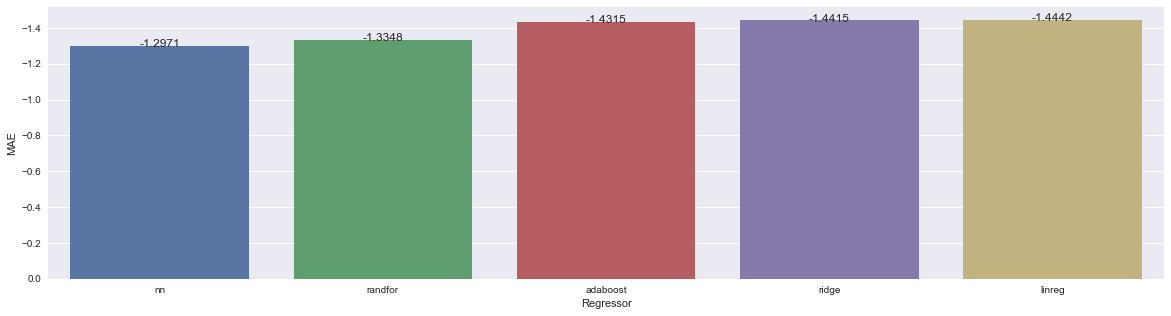

In [354]:
# let's create a list of models to test out
models = []

models.append(('nn', MLPRegressor()))
models.append(('linreg', LinearRegression()))
models.append(('ridge', Ridge()))
models.append(('randfor', RandomForestRegressor()))
models.append(('adaboost', AdaBoostRegressor()))

# loop through models to test
names = []
scores = []

for name, model in models:
    kfold = KFold(n_splits=10, random_state=10)
    score = cross_val_score(model, X_train, y_train, cv=kfold,
                           scoring='neg_mean_absolute_error').mean()
    names.append(name)
    scores.append(score)

# visualizing the model performances
kf_cross_val = pd.DataFrame({'Name': names, 'Score': scores}).sort_values('Score', ascending=False)
axis = sns.barplot(x = 'Name', y = 'Score', data = kf_cross_val)
axis.set(xlabel='Regressor', ylabel='MAE')

for p in axis.patches:
    height = p.get_height()
    axis.text(p.get_x() + p.get_width()/2, height + 0.005, '{:1.4f}'.format(height), ha='center')
plt.gca().invert_yaxis()
plt.show()

__Takeaway__: Here, we're after the model with the lowest mean absolute error (ignore the - in front of the scores, it's something sklearn is doing with the calculations). In this case, it seems that the neural network and random forest model works best out of the box. We will, however, try a couple of them out and tune their parameters to truly reveal their potential. 

We will use linear regression as our benchmark, since it is the simplest to set up.

Mean Absolute Error: 1.466183740819805


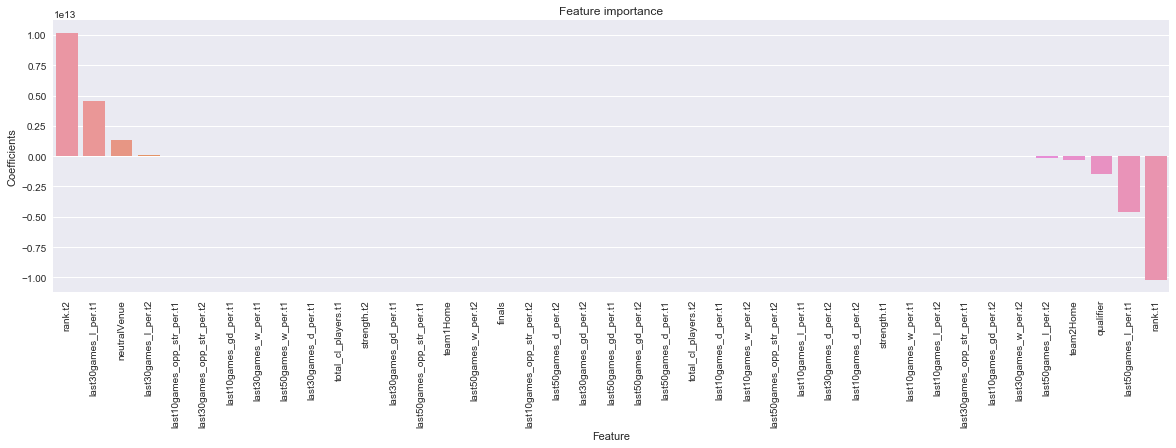

In [355]:
# let's try out linear regression to create a baseline to compare 
# other algorithms by
linreg = LinearRegression()

# fit the model to the training data
linreg.fit(X_train, y_train)

# let the model make predictions on the test data
linreg_y_pred = linreg.predict(X_test)

# MAE
print('Mean Absolute Error: {}'.format(mean_absolute_error(y_test, linreg_y_pred)))

# here we see the values given the most weight in the predictions
linreg_coef = pd.DataFrame({'Feature': df_train.columns, 
                           'Coefficients': np.transpose(linreg.coef_)}).sort_values(['Coefficients'], ascending=False)
sns.barplot(linreg_coef.Feature, linreg_coef.Coefficients)
plt.xticks(rotation=90)
plt.title('Feature importance')
plt.show()

__Takeaway__: Linear Regression, the simpelst of our models, performed okay on the first test set. Let's try out the other algorithms and use this as our baseline! The score to beat is MAE = 1.466183740819805.

Note that the feature importances diagram show us that the model actually only really takes about 4 feature into account when predicting. All of our nice rolling window feature indicating the form of the teams aren't really used. 

In [356]:
# let's try ridge regression

# values of alpha we want to try out
ridge_alphas = [1, 0.1, 0.01, 0.001, 0.0001, 0]

# for ridge regression, we'll do some parameter tuning using grid search
ridge_cv = GridSearchCV(estimator = Ridge(), param_grid={'alpha': ridge_alphas}, scoring='neg_mean_absolute_error', cv=5 )

# fit the model
ridge_cv.fit(X_train, y_train)

ridge_cv.grid_scores_, ridge_cv.best_params_, ridge_cv.best_score_

([mean: -1.44211, std: 0.02052, params: {'alpha': 1},
  mean: -1.44240, std: 0.02021, params: {'alpha': 0.1},
  mean: -1.44244, std: 0.02018, params: {'alpha': 0.01},
  mean: -1.44244, std: 0.02017, params: {'alpha': 0.001},
  mean: -1.44244, std: 0.02017, params: {'alpha': 0.0001},
  mean: -1.44976, std: 0.01882, params: {'alpha': 0}],
 {'alpha': 1},
 -1.44211290836848)

Mean Absolute Error: 1.4652002997707256


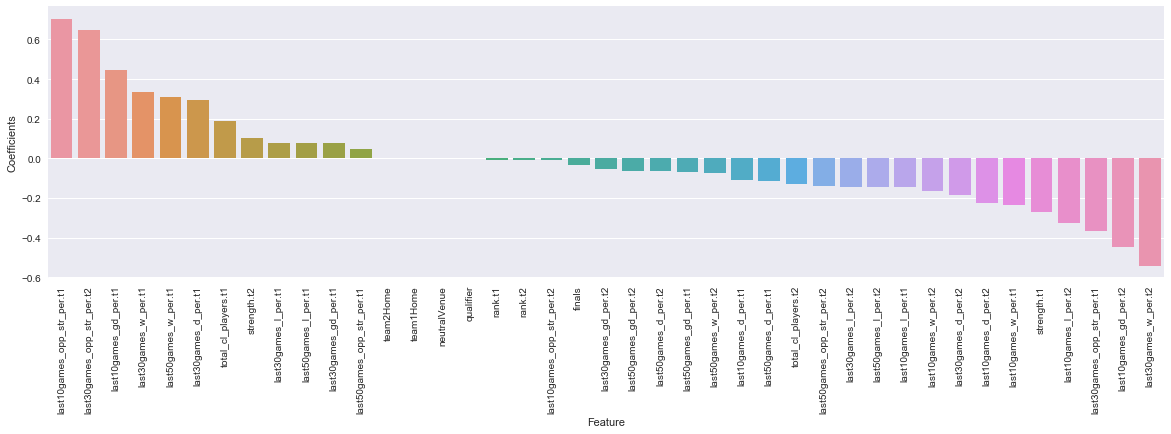

In [357]:
# create the model using our optimal hyperparameter
ridge = Ridge(alpha=1)

# fit the model to the test data
ridge.fit(X_train, y_train)

# make predictions
ridge_y_pred = ridge.predict(X_test)

# MAE
print('Mean Absolute Error: {}'.format(mean_absolute_error(y_test, ridge_y_pred)))

# here we see the values given the most weight in the predictions
ridge_coef = pd.DataFrame({'Feature': df_train.columns, 
                           'Coefficients': np.transpose(ridge.coef_)}).sort_values(['Coefficients'], ascending=False)
sns.barplot(ridge_coef.Feature, ridge_coef.Coefficients)
plt.xticks(rotation=90)
plt.show()

__Takeaway__: Ridge regression improved the accuracy of our model - however only slight with a score of 1.4652002997707256. 

The difference between the two models is that Ridge regression uses L2 regularization, which helps our model with potential issues of overfitting the data by adding a penalty to the importance of the features. Overfitting means that our model is picking up noise as something it uses in it's predictions, resulting in poor prediction on new data. It is a matter of fitting too well to the training data and not being able to predict on unseen data.

We see that the importance of the features here are different than from the basic linear regression model. Here, all but one feature, team2Home, are used to helpt predict the outcomes. And we see that our form indicating features are used a lot.

In [28]:
# let's try the neural network

# dictionary of the hyperparameters we'll tune
nn_param_grid1 = {
    'hidden_layer_sizes': [(25,), (50,), (100,), (150,), (200,),
                          (25,2), (50,2), (100,2), (150,2), (200,2),
                          (25,3), (50,3), (100,3), (150,3), (200,3)
                          ]
}

# using gridsearch to tune parameters
nn_cv1 = GridSearchCV(estimator = MLPRegressor(random_state=42), 
                      param_grid=nn_param_grid1, scoring='neg_mean_absolute_error', cv=3)

# fit the gridsearch model
nn_cv1.fit(scaledX_train, y_train)

# printing scores and best parameters
nn_cv1.grid_scores_, nn_cv1.best_params_, nn_cv1.best_score_

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -1.36272, std: 0.02383, params: {'hidden_layer_sizes': (25,)},
  mean: -1.35583, std: 0.01960, params: {'hidden_layer_sizes': (50,)},
  mean: -1.35837, std: 0.02593, params: {'hidden_layer_sizes': (100,)},
  mean: -1.35987, std: 0.01685, params: {'hidden_layer_sizes': (150,)},
  mean: -1.34800, std: 0.02307, params: {'hidden_layer_sizes': (200,)},
  mean: -1.36132, std: 0.01923, params: {'hidden_layer_sizes': (25, 2)},
  mean: -1.54670, std: 0.10234, params: {'hidden_layer_sizes': (50, 2)},
  mean: -1.37512, std: 0.00954, params: {'hidden_layer_sizes': (100, 2)},
  mean: -1.36195, std: 0.02550, params: {'hidden_layer_sizes': (150, 2)},
  mean: -1.37626, std: 0.00390, params: {'hidden_layer_sizes': (200, 2)},
  mean: -1.36249, std: 0.02341, params: {'hidden_layer_sizes': (25, 3)},
  mean: -1.39685, std: 0.01982, params: {'hidden_layer_sizes': (50, 3)},
  mean: -1.37854, std: 0.00960, params: {'hidden_layer_sizes': (100, 3)},
  mean: -1.35345, std: 0.01943, params: {'hidden_layer

In [29]:
# we now use this optimal size of hidden layers
# in this case 1 hidden layer with 200 hidden units

# now we'll tune the hyperparameter for the actiovation function used
nn_param_grid2 = {
    'activation': ['identity', 'logistic', 'tanh', 'relu']
}

# using gridsearch to tune parameters using the parameters tuned before
nn_cv2 = GridSearchCV(estimator=MLPRegressor(hidden_layer_sizes=(200,), random_state=42), 
                      param_grid=nn_param_grid2, scoring='neg_mean_absolute_error', cv=3)

# fit the gridsearch model
nn_cv2.fit(scaledX_train, y_train)

# printing scores and best parameters
nn_cv2.grid_scores_, nn_cv2.best_params_, nn_cv2.best_score_

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -1.39285, std: 0.01786, params: {'activation': 'identity'},
  mean: -1.39510, std: 0.01471, params: {'activation': 'logistic'},
  mean: -1.39145, std: 0.01828, params: {'activation': 'tanh'},
  mean: -1.34800, std: 0.02307, params: {'activation': 'relu'}],
 {'activation': 'relu'},
 -1.3480034152324278)

In [30]:
# the best performing activation function was the one we already used

# now we'll tune the hyperparameters for the solver used by the network
nn_param_grid3 = {
    'solver': ['lbfgs', 'sgd', 'adam']
}

# using gridsearch to tune parameters using the parameters tuned before
nn_cv3 = GridSearchCV(estimator=MLPRegressor(hidden_layer_sizes=(200,), activation='relu', random_state=42),
                     param_grid=nn_param_grid3, scoring='neg_mean_absolute_error', cv=3)

# fit the gridsearch model
nn_cv3.fit(scaledX_train, y_train)

# printing scores and best parameters
nn_cv3.grid_scores_, nn_cv3.best_params_, nn_cv3.best_score_

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -1.36771, std: 0.02538, params: {'solver': 'lbfgs'},
  mean: -1.37635, std: 0.01509, params: {'solver': 'sgd'},
  mean: -1.34800, std: 0.02307, params: {'solver': 'adam'}],
 {'solver': 'adam'},
 -1.3480034152324278)

In [31]:
# the best solver was the one we were already using by default

# now we'll tune the hyperparameters for learning rates and alpha
nn_param_grid4 = {
    'alpha': [1, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0],
    'learning_rate_init': [1, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001]
}

# using gridsearch to tune parameters using the parameters tuned before
nn_cv4 = GridSearchCV(estimator=MLPRegressor(hidden_layer_sizes=(200,), activation='relu', 
                                             solver='adam', random_state=42), 
                      param_grid=nn_param_grid4, scoring='neg_mean_absolute_error', cv=3)

# fit the gridsearch model
nn_cv4.fit(scaledX_train, y_train)

# printing scores and best parameters
nn_cv4.grid_scores_, nn_cv4.best_params_, nn_cv4.best_score_

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklea

([mean: -1.39155, std: 0.02745, params: {'alpha': 1, 'learning_rate_init': 1},
  mean: -1.40850, std: 0.02318, params: {'alpha': 1, 'learning_rate_init': 0.3},
  mean: -1.37766, std: 0.02437, params: {'alpha': 1, 'learning_rate_init': 0.1},
  mean: -1.38409, std: 0.02299, params: {'alpha': 1, 'learning_rate_init': 0.03},
  mean: -1.36187, std: 0.01953, params: {'alpha': 1, 'learning_rate_init': 0.01},
  mean: -1.36193, std: 0.02291, params: {'alpha': 1, 'learning_rate_init': 0.003},
  mean: -1.36200, std: 0.01897, params: {'alpha': 1, 'learning_rate_init': 0.001},
  mean: -1.38620, std: 0.02552, params: {'alpha': 0.3, 'learning_rate_init': 1},
  mean: -1.39879, std: 0.01641, params: {'alpha': 0.3, 'learning_rate_init': 0.3},
  mean: -1.39098, std: 0.03613, params: {'alpha': 0.3, 'learning_rate_init': 0.1},
  mean: -1.36117, std: 0.02140, params: {'alpha': 0.3, 'learning_rate_init': 0.03},
  mean: -1.36238, std: 0.02227, params: {'alpha': 0.3, 'learning_rate_init': 0.01},
  mean: -1.358

In [33]:
# let's use the tuned parameters for our neural network model and make predictions

# create our model with the tuned hyperparameter values
nn = MLPRegressor(hidden_layer_sizes=(200,), activation='relu', 
                  solver='adam', alpha=0.003, learning_rate_init=0.001, random_state=42)

# fit the model 
nn.fit(scaledX_train, y_train)

# make predictions
nn_y_pred = nn.predict(scaledX_test)

# MAE
print('Mean Absolute Error: {}'.format(mean_absolute_error(y_test, nn_y_pred)))


Mean Absolute Error: 1.3505862352751343


__Takeaway__: The neural network performed a lot better! We went from 1.3937897750439279 to 1.3505862352751343. Let's check out the last two models though. But so far we have a winner!

In [127]:
# time to try the adaboost algorithm

# we'll start out by tuning the number of trees in the decision tree
# along with the learning rate because these two depend on each other

ada_param_grid1 = {
    'n_estimators': [300, 400, 500, 600, 700, 800],
    'learning_rate': [0.1, 0.03, 0.01] 
}

# using gridsearch to tune parameters
ada_cv = GridSearchCV(estimator=AdaBoostRegressor(random_state=42), param_grid=ada_param_grid1,
                      scoring='neg_mean_absolute_error', cv=3)

# fit the model to training data
ada_cv.fit(X_train, y_train)

# printing scores and best parameters
ada_cv.grid_scores_, ada_cv.best_params_, ada_cv.best_score_

([mean: -1.38281, std: 0.02312, params: {'learning_rate': 0.1, 'n_estimators': 300},
  mean: -1.38281, std: 0.02312, params: {'learning_rate': 0.1, 'n_estimators': 400},
  mean: -1.38281, std: 0.02312, params: {'learning_rate': 0.1, 'n_estimators': 500},
  mean: -1.38281, std: 0.02312, params: {'learning_rate': 0.1, 'n_estimators': 600},
  mean: -1.38281, std: 0.02312, params: {'learning_rate': 0.1, 'n_estimators': 700},
  mean: -1.38281, std: 0.02312, params: {'learning_rate': 0.1, 'n_estimators': 800},
  mean: -1.38028, std: 0.01979, params: {'learning_rate': 0.03, 'n_estimators': 300},
  mean: -1.37990, std: 0.02046, params: {'learning_rate': 0.03, 'n_estimators': 400},
  mean: -1.38003, std: 0.02072, params: {'learning_rate': 0.03, 'n_estimators': 500},
  mean: -1.38009, std: 0.02179, params: {'learning_rate': 0.03, 'n_estimators': 600},
  mean: -1.38016, std: 0.02165, params: {'learning_rate': 0.03, 'n_estimators': 700},
  mean: -1.38032, std: 0.02149, params: {'learning_rate': 0.

In [128]:
# let's check out which loss function gives us the best returns

ada_param_grid2 = {
    'loss': ['linear', 'square', 'exponential']
}

ada_cv2 = GridSearchCV(estimator=AdaBoostRegressor(learning_rate=0.03, n_estimators=400, random_state=42),
                        param_grid=ada_param_grid2, scoring='neg_mean_absolute_error', cv=3)

# fit the model to training data
ada_cv2.fit(X_train, y_train)

# printing scores and best parameters
ada_cv2.grid_scores_, ada_cv2.best_params_, ada_cv2.best_score_

([mean: -1.37990, std: 0.02046, params: {'loss': 'linear'},
  mean: -1.38185, std: 0.02244, params: {'loss': 'square'},
  mean: -1.38198, std: 0.01962, params: {'loss': 'exponential'}],
 {'loss': 'linear'},
 -1.3798999410452295)

In [129]:
# our model's performance didn't improve here, because we already used
# the linear loss function

# create our model
ada = AdaBoostRegressor(learning_rate=0.03, n_estimators=400, loss='linear', random_state=42)

# fit the model
ada.fit(X_train, y_train)

# time for predictions
ada_y_pred = ada.predict(X_test)

# MAE
print('Mean Absolute Error: {}'.format(mean_absolute_error(y_test, ada_y_pred)))

Mean Absolute Error: 1.3736736846399398


__Takeaway__: Better than Linear Regression and Ridge regression, but not better than our Neural Network. Let's try the last model now.

In [34]:
# Let's try to randomly search a grid of all parameters we want to tune

# number of trees in the random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]

# number of featuers to consider
max_features = ['auto', 'sqrt']

# maximum number of levels in the tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)

# minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# method of selecting samples for traning each tree
bootstrap = [True, False]

# creating the random grid
random_grid= {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                               n_iter=100, cv=3, verbose=2, random_state=42, 
                               n_jobs=-1, scoring='neg_mean_absolute_error')

rf_random.fit(X_train, y_train)

rf_random.best_params_, rf_random.best_score_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 47.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 96.5min finished
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -1.35080, std: 0.02167, params: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True},
  mean: -1.34622, std: 0.02335, params: {'n_estimators': 2000, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True},
  mean: -1.34783, std: 0.02393, params: {'n_estimators': 1200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False},
  mean: -1.74110, std: 0.01908, params: {'n_estimators': 2000, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 30, 'bootstrap': False},
  mean: -1.34574, std: 0.02344, params: {'n_estimators': 1600, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True},
  mean: -1.35184, std: 0.02204, params: {'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth'

In [35]:
# now that we have used random search to find some optimal parameters,
# we'll continue looking into the best hyperparameters using grid search

# creating a paramter grid based on the results from random search
randfor_param_grid1 = {
    'bootstrap': [True],
    'max_depth': [40, 50, 60],
    'max_features': [5, 6, 7],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [9, 10, 11],
    'n_estimators': [700, 800, 900]
}

randfor_cv = GridSearchCV(estimator=RandomForestRegressor(), param_grid=randfor_param_grid1, 
                          scoring='neg_mean_absolute_error', cv=3)

randfor_cv.fit(X_train, y_train)

# printing scores and best parameters
randfor_cv.best_params_, randfor_cv.best_score_

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -1.34707, std: 0.02298, params: {'bootstrap': True, 'max_depth': 40, 'max_features': 5, 'min_samples_leaf': 3, 'min_samples_split': 9, 'n_estimators': 700},
  mean: -1.34555, std: 0.02229, params: {'bootstrap': True, 'max_depth': 40, 'max_features': 5, 'min_samples_leaf': 3, 'min_samples_split': 9, 'n_estimators': 800},
  mean: -1.34635, std: 0.02273, params: {'bootstrap': True, 'max_depth': 40, 'max_features': 5, 'min_samples_leaf': 3, 'min_samples_split': 9, 'n_estimators': 900},
  mean: -1.34573, std: 0.02137, params: {'bootstrap': True, 'max_depth': 40, 'max_features': 5, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 700},
  mean: -1.34608, std: 0.02198, params: {'bootstrap': True, 'max_depth': 40, 'max_features': 5, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 800},
  mean: -1.34671, std: 0.02197, params: {'bootstrap': True, 'max_depth': 40, 'max_features': 5, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 900},
  mean:

Mean Absolute Error: 1.3252561268471368


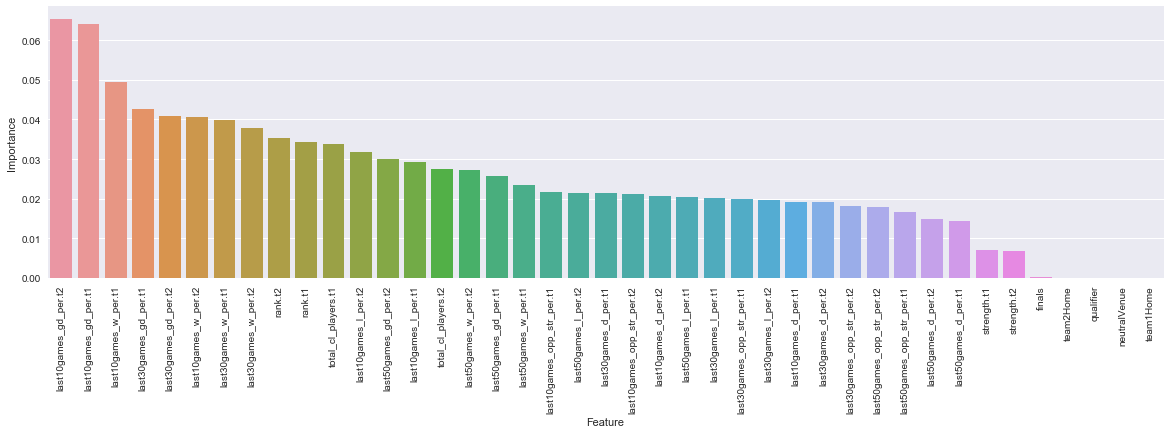

In [358]:
# create our model
randfor = RandomForestRegressor(bootstrap=True, max_depth=60, max_features=5, min_samples_leaf=4,
                           min_samples_split=9, n_estimators=700)

# fit the model
randfor.fit(X_train, y_train)

# time for predictions
randfor_y_pred = randfor.predict(X_test)

# MSE
print('Mean Absolute Error: {}'.format(mean_absolute_error(y_test, randfor_y_pred)))

# here we see the values given the most weight in the predictions
randfor_coef = pd.DataFrame({'Feature': df_train.columns, 
                           'Importance': randfor.feature_importances_}).sort_values(['Importance'], ascending=False)
sns.barplot(randfor_coef.Feature, randfor_coef.Importance)
plt.xticks(rotation=90)
plt.show()


In [361]:
# let's test the predictor on one last validation set

randfor_y_pred = randfor.predict(test_X)

# MSE
print('Mean Absolute Error: {}'.format(mean_absolute_error(test_y, randfor_y_pred)))

Mean Absolute Error: 1.213493333118953


__Takeaway__: The best score yet! We'll use this as our final model for making predictions. It performed even better on new, unseen data than on the training data.

In [365]:
# list of nations
wc_nations_list = list(wc_teams['name'].values)

# selecting only the World Cup nations
temp = team_features[team_features.name.isin(wc_nations_list)]

# get the teams' latest performance metrics
idx = temp.groupby('name')['date'].transform(max) == temp['date']
temp = temp[idx]

matches_predict = pd.DataFrame()

# get all possible combinations of matchups
for home, away in combinations(wc_teams['name'], 2):
    matches_predict = matches_predict.append({'team1': home, 'team2': away}, ignore_index=True)

matches_predict = matches_predict.merge(temp, how='left',left_on=['team1'], 
                                        right_on=['name'])

matches_predict = matches_predict.merge(temp, how='left',left_on=['team2'], 
                                        right_on=['name'], suffixes=['.t1', '.t2'])

matches_predict = matches_predict[matches_predict.team1 != matches_predict.team2]

# whenever Russia plays, they are the home team, else it's neutral
matches_predict['team1Home'] = np.where(matches_predict.team1 == 'RUS', True, False)
matches_predict['team2Home'] = np.where(matches_predict.team2 == 'RUS', True, False)
matches_predict['neutralVenue'] = np.where((matches_predict.team1Home == False) & 
                                           (matches_predict.team2Home == False), True, False)
# this is not qualification
matches_predict['qualifier'] = False

# this is finals
matches_predict['finals'] = True

# select the features we'll use with our prediction model
matches_predict = matches_predict[[
    'team1',
    'team2',
    'team1Home',
    'team2Home',
    'neutralVenue',
    'qualifier',
    'finals',
    'strength.t1',
    'strength.t2',
    'rank.t1',
    'rank.t2',
    'total_cl_players.t1',
    'total_cl_players.t2',
    'last10games_w_per.t1',
    'last30games_w_per.t1',
    'last50games_w_per.t1',
    'last10games_l_per.t1',
    'last30games_l_per.t1',
    'last50games_l_per.t1',
    'last10games_d_per.t1',
    'last30games_d_per.t1',
    'last50games_d_per.t1',
    'last10games_gd_per.t1',
    'last30games_gd_per.t1',
    'last50games_gd_per.t1',
    'last10games_opp_str_per.t1',
    'last30games_opp_str_per.t1',
    'last50games_opp_str_per.t1',
    'last10games_w_per.t2',
    'last30games_w_per.t2',
    'last50games_w_per.t2',
    'last10games_l_per.t2',
    'last30games_l_per.t2',
    'last50games_l_per.t2',
    'last10games_d_per.t2',
    'last30games_d_per.t2',
    'last50games_d_per.t2',
    'last10games_gd_per.t2',
    'last30games_gd_per.t2',
    'last50games_gd_per.t2',
    'last10games_opp_str_per.t2',
    'last30games_opp_str_per.t2',
    'last50games_opp_str_per.t2',
]]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 496 entries, 0 to 495
Data columns (total 73 columns):
team1                         496 non-null object
team2                         496 non-null object
matchId.t1                    496 non-null int32
date.t1                       496 non-null datetime64[ns]
name.t1                       496 non-null object
opponentName.t1               496 non-null object
homeVenue.t1                  496 non-null bool
neutralVenue.t1               496 non-null bool
goals_self.t1                 496 non-null int64
goals_opp.t1                  496 non-null int64
goals_diff.t1                 496 non-null int64
w.t1                          496 non-null bool
l.t1                          496 non-null bool
d.t1                          496 non-null bool
qualifier.t1                  496 non-null bool
finals.t1                     496 non-null bool
fifa_code.t1                  496 non-null object
strength.t1                   496 non-null float64
tota

In [367]:
# drop the team1 and team2 columns
pred_features = matches_predict.drop(columns=['team1', 'team2'])

# convert our DataFrame to array
pred_features = pred_features.values

# standardize the features
pred_features = scaler.fit_transform(pred_features)

# now we'll predict the outcomes for all possible World Cup 2018 matchups
predictions = randfor.predict(pred_features)

In [368]:
# add the predictions to the dataframe
matches_predict['outcome'] = predictions

In [369]:
# select columns we want to export to csv
predictions_csv = matches_predict[['team1', 'team2', 'outcome']]

# read to csv file
predictions_csv.to_csv('C:\\Data_Science\\World Cup 2018\\predictionsfinal.csv', index=False)